In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# encodage des mots en Int
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
#import cv2 # erreur import
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

# pour parser le fichier train.json
import json

Using TensorFlow backend.


In [3]:
with open('train.json', 'r') as f:
    datas = json.load(f) # id, cuisine, ingredients[]

csv = []
occurence = dict()
total_plats = dict()
total_ingredients = dict()

for data in datas:
    nb_ingredients = len(data)
    for ingredient in data['ingredients']:
        cuisine = data['cuisine']
        id = str(data['id'])
        
        # Ajout de la ligne id-cuisine-ingredient
        tmp = dict()
        tmp['id'] = id
        tmp['cuisine'] = cuisine
        tmp['ingredient'] = ingredient
        csv.append(tmp)
        
        # Comptage de l'occurence
        if not cuisine in occurence:
            occurence[cuisine] = dict()
        if not ingredient in occurence[cuisine]:
            occurence[cuisine][ingredient] = 0
        occurence[cuisine][ingredient] += 1
        
        # Comptage du nombre d'ingredients de chaque plat
        if not id in total_ingredients:
            total_ingredients[id] = 0
        total_ingredients[id] += 1
        
    # Comptage du nombre de plats par type de cuisine
    if not cuisine in total_plats:
        total_plats[cuisine] = 0
    total_plats[cuisine] += 1

# Ajout des occurences/total_plats dans le CSV
for ligne in csv:
    cuisine = ligne['cuisine']
    ingredient = ligne['ingredient']
    id = ligne['id']
    occ = occurence[cuisine][ingredient]
    ingrs = total_ingredients[id]
    pls = total_plats[cuisine]
    poids1 = 1 / ingrs
    poids2 = occ / pls
    poids3 = 1 / pls
    
    ligne['occurence'] = occ
    ligne['ingredients_plat'] = ingrs
    ligne['recettes_cuisine'] = pls
    ligne['poids_ingredient_recette'] = poids1 # poids de l'ingrédient dans la recette
    ligne['poids_ingredient_cuisine'] = poids2 # poids de l'ingrédient dans le type de cuisine
    ligne['poids_cuisine'] = poids3 # poids de la cuisine dans tous les types de cuisines
    #ligne['poids'] = poids # poids final
    
    ligne['val_relation'] = 1

# $ingredients contient tous les ingredients possibles
# $total_plats contient le nombre total de plats de chaque type de cuisine
# $total_ingredients contient le nombre total d'ingrédient de chaque plat


train = pd.DataFrame(csv)

In [4]:
df = train.copy()

In [5]:
df.head()

,cuisine,id,ingredient,ingredients_plat,occurence,poids_cuisine,poids_ingredient_cuisine,poids_ingredient_recette,recettes_cuisine,val_relation
0,greek,10259,romaine lettuce,9,39,0.000851,0.033191,0.111111,1175,1
1,greek,10259,black olives,9,31,0.000851,0.026383,0.111111,1175,1
2,greek,10259,grape tomatoes,9,26,0.000851,0.022128,0.111111,1175,1
3,greek,10259,garlic,9,216,0.000851,0.183830,0.111111,1175,1
4,greek,10259,pepper,9,203,0.000851,0.172766,0.111111,1175,1


In [6]:
print(total_plats)

{'greek': 1175, 'southern_us': 4320, 'filipino': 755, 'indian': 3003, 'jamaican': 526, 'spanish': 989, 'italian': 7838, 'mexican': 6438, 'chinese': 2673, 'british': 804, 'thai': 1539, 'vietnamese': 825, 'cajun_creole': 1546, 'brazilian': 467, 'french': 2646, 'japanese': 1423, 'irish': 667, 'korean': 830, 'moroccan': 821, 'russian': 489}


In [7]:
# Encodage des valeurs

#le_cuisine = LabelEncoder()
#le_ingredient = LabelEncoder()

#df['cuisine'] = le_cuisine.fit_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.fit_transform(df['ingredient'])

# Pour inverser l'encodage il faudra utiliser ces deux lignes :
#df['cuisine'] = le_cuisine.inverse_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.inverse_transform(df['ingredient'])

#df.head()

In [8]:
df['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [9]:
df['ingredient'].unique()

array(['romaine lettuce', 'black olives', 'grape tomatoes', ...,
       'lop chong', 'tomato garlic pasta sauce',
       'crushed cheese crackers'], dtype=object)

In [ ]:
# Creation de la matrix

index = list(df['id'].unique())
columns = list(df['ingredient'].unique())
index = sorted(index)
columns = sorted(columns)

util_df = pd.pivot_table(data = df, values = 'val_relation', index = 'id', columns = 'ingredient')

In [48]:
util_df

ingredient,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
british,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
cajun_creole,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
filipino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
french,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
greek,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
indian,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
irish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [15]:
util_df = util_df.fillna(0)
util_df

ingredient,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
british,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
cajun_creole,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,0.0
filipino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
french,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,41.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,86.0,0.0
greek,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,47.0,0.0
indian,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0
irish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [16]:
X = util_df
model = NMF(n_components=6, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [17]:
W = pd.DataFrame(W, index, ["type_" + str(i+1) for i in range(len(W[0]))])
H = pd.DataFrame(H, ["type_" + str(i+1) for i in range(len(H))], columns)

In [18]:
print(W)
print(H)
# On peut utiliser sklearn mds pour représenter les ingrédients
# et les cuisines sur une carte 2D en calculant les distances

                type_1     type_2    type_3     type_4    type_5     type_6
brazilian     0.186564   0.495214  0.067933   0.172330  0.081040   0.171188
british       0.000000   0.147600  0.000000   0.000000  0.052116   2.095633
cajun_creole  4.950307   0.143910  0.000000   0.000000  0.000000   0.152340
chinese       0.176313   0.000000  6.719613   0.000000  0.000000   0.303791
filipino      0.519723   0.387809  0.842869   0.054473  0.244489   0.235220
french        0.000000   4.757073  0.092202   0.000000  0.040012   4.025797
greek         0.240206   3.979688  0.000000   0.193335  0.091662   0.000000
indian        0.000000   0.000000  0.000000   0.000000  4.052202   0.397178
irish         0.121901   0.182105  0.000000   0.000000  0.054584   1.641129
italian       0.102237  32.127643  0.020049   0.091710  0.000000   0.348192
jamaican      0.506193   0.153594  0.293126   0.134562  0.152411   0.389177
japanese      0.000000   0.000000  2.082001   0.000000  0.155227   0.616897
korean      

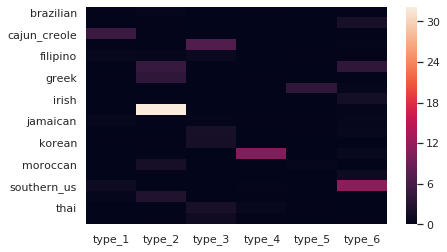

In [19]:
ax = sns.heatmap(W)

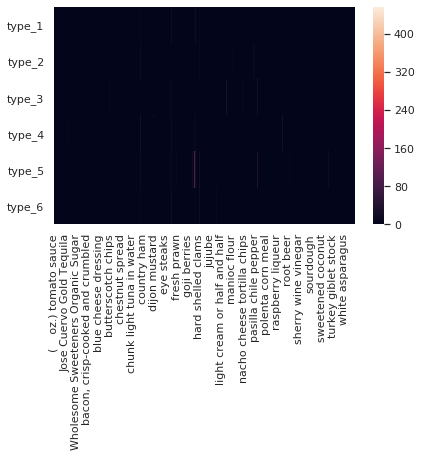

In [20]:
ay = sns.heatmap(H)

In [21]:
print(index) # cuisines
print(columns) # ingrédients

['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
['(    oz.) tomato sauce', '(   oz.) tomato paste', '(10 oz.) frozen chopped spinach', '(10 oz.) frozen chopped spinach, thawed and squeezed dry', '(14 oz.) sweetened condensed milk', '(14.5 oz.) diced tomatoes', '(15 oz.) refried beans', '1% low-fat buttermilk', '1% low-fat chocolate milk', '1% low-fat cottage cheese', '1% low-fat milk', '2 1/2 to 3 lb. chicken, cut into serving pieces', '2% low fat cheddar chees', '2% low-fat cottage cheese', '2% lowfat greek yogurt', '2% milk shredded mozzarella cheese', '2% reduced-fat milk', '25% less sodium chicken broth', '33% less sodium cooked deli ham', '33% less sodium cooked ham', '33% less sodium ham', '33% less sodium smoked fully cooked ham', '40% less sodium taco seasoning', '40% less sodium taco seasoning mix',

In [22]:
def avg_recette(tab):
    sortie = pd.Series([0.0 for i in range(len(H))], ["type_" + str(i+1) for i in range(len(H))])
    for ingr in tab:
        sortie += ingr
    sortie /= len(tab)
    return sortie

def avg_recette_bis(tab):
    return np.mean(tab, axis=0)

def get_tab_recette(id):
    print(id)
    ingredients = df.loc[(df['id'] == id)]['ingredient']
    tab = [H[ingr] for ingr in ingredients]
    return tab


In [29]:
# SELECT * FROM df WHERE df.id = '10259'
plat1_all = df.loc[(df['id'] == '10259')]
plat1_all

,cuisine,id,ingredient,ingredients_plat,occurence,poids_cuisine,poids_ingredient_cuisine,poids_ingredient_recette,recettes_cuisine
0,greek,10259,romaine lettuce,9,39,0.000851,0.033191,0.111111,1175
1,greek,10259,black olives,9,31,0.000851,0.026383,0.111111,1175
2,greek,10259,grape tomatoes,9,26,0.000851,0.022128,0.111111,1175
3,greek,10259,garlic,9,216,0.000851,0.183830,0.111111,1175
4,greek,10259,pepper,9,203,0.000851,0.172766,0.111111,1175
5,greek,10259,purple onion,9,186,0.000851,0.158298,0.111111,1175
6,greek,10259,seasoning,9,3,0.000851,0.002553,0.111111,1175
7,greek,10259,garbanzo beans,9,23,0.000851,0.019574,0.111111,1175
8,greek,10259,feta cheese crumbles,9,252,0.000851,0.214468,0.111111,1175


In [30]:
plat1_ingrs = plat1_all['ingredient']
plat1_ingrs

0         romaine lettuce
1            black olives
2          grape tomatoes
3                  garlic
4                  pepper
5            purple onion
6               seasoning
7          garbanzo beans
8    feta cheese crumbles
Name: ingredient, dtype: object

In [32]:
plat1_val = [H[ingr] for ingr in plat1_ingrs]
plat1_val

[type_1     2.358476
 type_2     1.114740
 type_3     2.288406
 type_4    10.035157
 type_5     0.781966
 type_6     0.299765
 Name: romaine lettuce, dtype: float64, type_1    0.215257
 type_2    2.168339
 type_3    0.000000
 type_4    8.852971
 type_5    0.000000
 type_6    0.285139
 Name: black olives, dtype: float64, type_1    0.953449
 type_2    3.022501
 type_3    0.122364
 type_4    5.012839
 type_5    0.896359
 type_6    0.785033
 Name: grape tomatoes, dtype: float64, type_1     75.843278
 type_2     44.406225
 type_3    114.563895
 type_4    125.931207
 type_5    177.575687
 type_6      9.546213
 Name: garlic, dtype: float64, type_1    42.428850
 type_2    29.126664
 type_3    23.213074
 type_4    74.753648
 type_5    48.741586
 type_6    39.331810
 Name: pepper, dtype: float64, type_1     8.296461
 type_2    11.069353
 type_3     5.418615
 type_4    59.756353
 type_5    42.537345
 type_6     5.301820
 Name: purple onion, dtype: float64, type_1    5.007936
 type_2    0.315992
 

In [33]:
np.mean(plat1_val, axis=0)

array([15.31836676, 10.5390342 , 16.33991206, 32.33496738, 31.46816093,
        6.25727557])

In [24]:
# Création d'une liste des id de plats
id_plats = df['id'].unique()
id_plats

array(['10259', '25693', '20130', ..., '2238', '41882', '2362'],
      dtype=object)

In [25]:
recette = get_tab_recette(id_plats[0])
test_recette = avg_recette(recette)
test_recette_bis = avg_recette_bis(recette)
print(test_recette)
print(test_recette_bis)

10259
type_1    15.318367
type_2    10.539034
type_3    16.339912
type_4    32.334967
type_5    31.468161
type_6     6.257276
dtype: float64
[15.31836676 10.5390342  16.33991206 32.33496738 31.46816093  6.25727557]


In [26]:
print(W)

                type_1     type_2    type_3     type_4    type_5     type_6
brazilian     0.186564   0.495214  0.067933   0.172330  0.081040   0.171188
british       0.000000   0.147600  0.000000   0.000000  0.052116   2.095633
cajun_creole  4.950307   0.143910  0.000000   0.000000  0.000000   0.152340
chinese       0.176313   0.000000  6.719613   0.000000  0.000000   0.303791
filipino      0.519723   0.387809  0.842869   0.054473  0.244489   0.235220
french        0.000000   4.757073  0.092202   0.000000  0.040012   4.025797
greek         0.240206   3.979688  0.000000   0.193335  0.091662   0.000000
indian        0.000000   0.000000  0.000000   0.000000  4.052202   0.397178
irish         0.121901   0.182105  0.000000   0.000000  0.054584   1.641129
italian       0.102237  32.127643  0.020049   0.091710  0.000000   0.348192
jamaican      0.506193   0.153594  0.293126   0.134562  0.152411   0.389177
japanese      0.000000   0.000000  2.082001   0.000000  0.155227   0.616897
korean      

In [37]:
# faire une fonction qui multiplie les valeurs d'une recette avec les max des types de cuisine